Test code to examine Lake Catchment Areas

In [1]:
import ECCO_functions_v2 as ECCO

import csv  # <<-- dont forget to add this ti function file

In [2]:
#from __future__ import print_function

from collections import OrderedDict
import pandas as pd
import osgeo.ogr
import sys, time, os, json, glob
import numpy as np
import pyproj
import h5py

import random

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Read back catchment metadata from Catchment_weights_Meta() function..
catch_meta = pd.read_csv('Catchments/Metadata/Catchment_meta.csv')
catch_meta = catch_meta.set_index('EB_id')

#catch_meta.area['d30b2']
#for i in catch_meta.index[0:10]:
#    print i

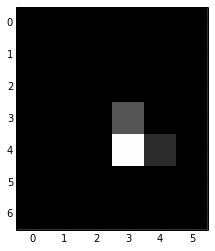

Shapes: (7, 6) (7, 6) (10, 7, 6)
0 0.222642 [ 1.  1.  1.]
1 0.659245 [ 1.  1.  1.]
2 0.118113 [ 1.  1.  1.]
3

IndexError: index out of bounds

In [15]:
# Need to add a line that checks number of pixels etc...
#a2 = get_catchweight(tmp_ebid='b82ce')  # example of pulling the catchment weights back with metadata
plt.imshow(a2,interpolation='none',cmap=plt.cm.gray)
plt.show()
#print(np.sum(a2))

#for n in catch_meta.index[24009:24010]:
#    tmpid = n
#    print tmpid,catch_meta.npix[tmpid]

csim2[0,aaa]=10.

#plt.imshow(csim2[:,:,0],interpolation='none',cmap=plt.cm.gray)
#plt.show()

aaa = (a2 != 0.)   # Indx where weights exist
#print(aaa)
print 'Shapes:',np.shape(aaa),np.shape(a2),np.shape(csim)
#dim1, dim2, dim3 = csim.shape
#d = csim.reshape((dim1, dim2 * dim3))[:, aaa] ## n_time x n_pixels

aaa = (a2 != 0.)   # Indx where weights exist
wm = a2[aaa].flatten()  # get a small array of the weight pixels only
tmp_series = []
for n,pix in enumerate(csim[:,aaa]):  # Place climate data here,subset by truth-mask of weights
    print n,wm[n],pix
    tmp_series.append(wm[n]*pix)
tmp_series = np.array(tmp_series)
time_series = np.sum(tmp_series,axis=0)


(10, 7, 6)
(6, 7, 10)
[  1.00000000e+01   8.93287942e-02   2.13089325e-01   2.55739775e-01
   7.89525422e-01   6.46067076e-03   4.53443217e-01   2.43006060e-01
   7.25739388e-01   9.15719780e-02]
[ 0.16759638  0.65555276  0.79099501  0.47496523  0.26877049  0.09028364
  0.13590496  0.07787574  0.05724736  0.05203857]
[ 10.           0.931202     0.92012277   0.80373279   0.44123345
   0.33197187   0.43810808   0.78741406   0.59807598   0.79192429]


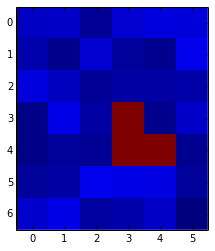

In [14]:
#print(aaa)

ctemp = np.rollaxis(csim2,1)
ctemp = np.rollaxis(ctemp,2)
print np.shape(csim)
print np.shape(ctemp)
for n in ctemp[aaa,:]:
    print n
    
plt.imshow(csim2[0,:,:],interpolation='none')
#np.rollaxis?

(7, 6)


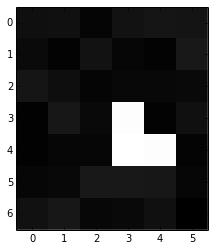

Shape covers 3  pixels
Actual weight values are : [ 0.22264151  0.65924531  0.1181132 ]
Pix weight cum. sum (should end as 1.0): [ 0.22264151  0.88188684  1.        ]


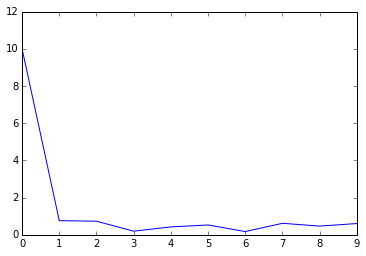

In [13]:
a2 = get_catchweight(tmp_ebid='b82ce')  # example of pulling the catchment weights back with metadata
#plt.imshow(a2,interpolation='none',cmap=plt.cm.gray)

xval,yval = np.shape(a2)
csim = np.ones((10,xval,yval)) 

csim2 = [[[random.random() for i in range(yval)] for j in range(xval)] for n in range(10)]
csim2 = np.array(csim2)
aaa = (a2 != 0.)   # Indx where weights exist
csim2[0,aaa]=10.

print np.shape(a2)
#print np.shape(csim)
#print np.shape(csim2)

plt.imshow(csim2[0,:,:],interpolation='none',cmap=plt.cm.gist_gray)
plt.show()
tseries = ECCO.Weighted_Mean_3D(weight_mask=a2,all_time_clim=csim2,chatty=True)
plt.plot(tseries)
plt.show()

In [390]:
def Weighted_Mean_3D(weight_mask,all_time_clim,chatty):
    '''Purpose    - Reads in the 2D weight mask (from Pixel_Weights
    function) and the trimmed data from TrimToLake and returns a
    weighted mean. This should be iterated for each time-step.
    Input    - weight_mask: Pixel weights
             - all_time_clim: the climate data (lat lon subset)
             from TrimToLake3D().
             - chatty: a true or false statement, if true, it will 
               print some info on the weighting process.
    Output   - val_out: the weighted mean value
    '''
    tvals = weight_mask != 0.   # Indx where weights exist
    if len(weight_mask[tvals]) < 1:
        print 'Error, no shape cover identified in weighted mask.'
        return
    if chatty:
        print 'Shape covers',len(weight_mask[tvals]),' pixels'
        print 'Actual weight values are :',weight_mask[tvals]
        print 'Pix weight cum. sum (should end as 1.0):',np.cumsum(weight_mask[tvals])
    wm = weight_mask[tvals].flatten()  # Get a small array of the weight pixels only
    tmp_series = []
    
    # Roll the axis so that from a loop I can pull back all time dimension for each pixl
    ctemp = np.rollaxis(all_time_clim,2) 
    ctemp = np.rollaxis(ctemp,2)
    
    for n,pix in enumerate(ctemp[tvals,:]):  # For each row (timeseries) of pixel data
        tmp_series.append(wm[n]*pix)         # append it
    tmp_series = np.array(tmp_series)
    time_series = np.sum(tmp_series,axis=0)
    return time_series


def Weighted_Mean_3D_old(weight_mask,all_time_clim,chatty):
    '''
    I THINK THIS IS BUGGY - so I created this old version to track 
    how it used to look. New changes in the non-old version above.
    Purpose    - Reads in the 2D weight mask (from Pixel_Weights
    function) and the trimmed data from TrimToLake and returns a
    weighted mean. This should be iterated for each time-step.
    Input    - weight_mask: Pixel weights
             - all_time_clim: the climate data (lat lon subset)
             - chatty: a true or false statement, if true, it will 
               print some info on the weighting process.
    Output   - val_out: the weighted mean value
    '''
    aaa = (weight_mask > 0.000).flatten()   # Indx where weights exist
    if (len(aaa) == 0):
        print 'Error: no lake cover identified! :('
    if (chatty == True):
        print 'Lake covers',len(weight_mask[aaa]),' pixels'
        print 'Actual weight values are :',weight_mask[aaa]
        print 'Cum. sum of pixel weights (should end as 1.0):',cumsum(weight_mask[aaa])
    dim1, dim2, dim3 = all_time_clim.shape
    d = all_time_clim.reshape((dim1, dim2 * dim3))[:, aaa] ## n_time x n_pixels
    wm = weight_mask.flatten()[aaa]
    val_out = np.dot(d, wm.reshape(len(wm), 1)) ## n_time x n_pixels dot n_pixels x 1
    return val_out

In [8]:
# Catchment specific function (to be added to function file after development)

def get_catchweight(tmp_ebid):
    '''
    From the hex EB_id (KID) value of a catchment covering more than one
    pixel, fetch the np array of the pre-calculated weight from the hdf5 
    file. N.b. this file has been pre-calculated, using the function
    Catchment_Weights_Meta(), and is a 65mb file required for the code to
    run correctly.
    Requies h5py module.
    '''
    with h5py.File('Catchments/Weights/catchment_weights.h5','r') as fp:
        tmparray = fp[tmp_ebid]
        tmparray = tmparray[:,:]
    return tmparray


def Reproj_Catchment(lake_feature,chatty=False):
    '''
    Takes the lowest level data from the Catchment shape file feature, and
    reprojects the coordinate system using PROJ (PyProj) to a WGS85 system.
    '''
    p1 = pyproj.Proj("+init=EPSG:25833")   # Projected system for lake catchments
    p2 = pyproj.Proj("+init=EPSG:4326")    # World Geodetic system
    tmp1=[]
    
    if lake_feature['geometry']['type'] == 'MultiPolygon':
        if chatty == True: print 'Multi-polygon type'
        for n in lake_feature['geometry']['coordinates'][0][0]:  #For every vertice pair...
            x,y=(pyproj.transform(p1,p2,n[0],n[1],z=None,radians=False)) # trans. coords. to WGS85
            tmp1.append([x,y])
        return tmp1
    else:
        if chatty == True: print 'Simple Polygon type'
        for n in lake_feature['geometry']['coordinates'][0]:  #For every vertice pair...
            x,y=(pyproj.transform(p1,p2,n[0],n[1],z=None,radians=False)) # trans. coords. to WGS85
            tmp1.append([x,y])
        return tmp1

def write_metadata_csv(mfname,meta_list):
    '''
    Writes a list of metadata (meta_list) to a csv file one
    line at a time, appending to the file. This means I dont
    need to keep all the data in memory at once.
    requires > import csv
    '''
    with open(mfname, 'a') as csvfile:
        metawriter = csv.writer(csvfile,delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
        metawriter.writerow(meta_list)
    return
    
def Write_HDF_weights(fw,EB_id,weights):
    '''
    Simple writing using H5py module in HDF5 format.
    (This should be used for the final program)
    '''
    dim1,dim2 = np.shape(weights)
    dset = fw.create_dataset(EB_id,(dim1,dim2,),dtype='f')
    dset[...]=weights
    return

 Simple Polygon type


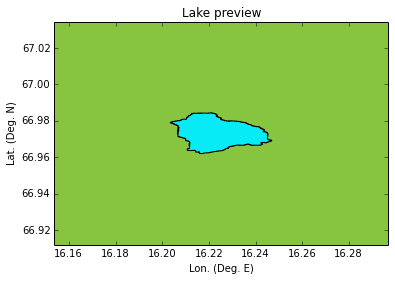

e9f40
Area in km^2: 2.79 , No. xy bound. points: 576


In [16]:
input_file = 'Catchments/ecco_biwa_catchments_part_1.shp'

n = 10

ShapeData = osgeo.ogr.Open(input_file)                  # Make a link to Lake Shape Files
TheLayer = ShapeData.GetLayer(iLayer=0)
feature1 = TheLayer.GetFeature(n)                      # Get individ. lake in shapefile
lake_feature = feature1.ExportToJson(as_object=True)
EB_id = hex(int(lake_feature['properties']['ebint']))[2:]


wgs85_xy = Reproj_Catchment(lake_feature=lake_feature,chatty=True)
lake_cart = ECCO.Path_LkIsl_ShpFile([wgs85_xy])
lake_rprj = ECCO.Path_Reproj(lake_cart,False)    # Reproj. lake to CORDEX plr. rotated

ECCO.Preview_Lake(lake_cart)        
print EB_id
print 'Area in km^2:', ECCO.Area_Lake_and_Islands(lake_cart),         
print ', No. xy bound. points:',len(lake_cart.vertices)


In [5]:
#lake_feature
lake_feature['geometry']['coordinates'][0]
p1 = pyproj.Proj("+init=EPSG:25833")   # Projected system for lake catchments
p2 = pyproj.Proj("+init=EPSG:4326")    # World Geodetic system
tmp1=[]
print np.shape(lake_feature['geometry']['coordinates'])
for i,n in enumerate(lake_feature['geometry']['coordinates'][0]):  #For every vertice pair...
    x,y=(pyproj.transform(p1,p2,n[0],n[1],z=None,radians=False)) # trans. coords. to WGS85
    tmp1.append([x,y])
    
print lake_feature['geometry']['type'] == 'MultiPolygon'

(1, 577, 2)
False


In [7]:
input_file = 'Catchments/ecco_biwa_catchments_part_3.shp'
ShapeData = osgeo.ogr.Open(input_file)                  # Make a link to Lake Shape Files
TheLayer = ShapeData.GetLayer(iLayer=0)

TheLayer.GetFeatureCount()

print(np.sum([91268, 91457, 92066]))

274791


In [43]:
def catchment_timeseries(nc_path, outputprefix,plots = False,rprt=False,sbar=False):
    '''
    Function to produce time series over catchment areas for a given input file of
    CORDEX data. Metadata and weights have been pre-calculated with the function
    Catchment_Weights_Meta().
    '''
    # Section for loading of data and opening of an output file
    if rprt:
        atime = time.time()
    
    clim_dat,rlat,rlon,timeCDX,metadata,txtfname = ECCO.Read_CORDEX_V2(nc_path) # CORDEX NetCDF Read file
    vname, m1, m2, dexp, m3, m4, m5, m6, drange_orignial = metadata        # Metadata of fname string
    var_type = clim_dat.standard_name                                      # What kind of CORDEX data?
    dat_loaded = clim_dat[:,:,:]                                           # Load CORDEX data into RAM
    rlat_loaded = rlat[:]
    rlon_loaded = rlon[:]
    
    thefilename = 'Catchment_'+str.split(nc_path,'/')[-1][:-3] 
    FILE= outputprefix + thefilename +'.h5'                # Set up HDF5 file output
    if os.path.isfile(FILE) == True:
        print 'File already exists: Overwriting...'
        os.remove(FILE)
    else:
        print 'Creating file: ',FILE
    f = h5py.File(FILE,'w')
    
    # Metadata contains EB_id(index), area, npix, xpix, ypix
    # Where the number of pixels is 1, we can use the xpix, ypix directly as the time series
    # Where the npix is larger than 1, we can call the precalculated array of weights.
    catch_meta = pd.read_csv('Catchments/Metadata/Catchment_meta.csv') # Metadata
    catch_meta = catch_meta.set_index('EB_id')              # Hex code is used as id
    
    lake_file='Catchments/ecco_biwa_catchments_part_1.shp'  # just for testing...
    ShapeData = osgeo.ogr.Open(lake_file)                   # Connection to catchment shapes
    TheLayer = ShapeData.GetLayer(iLayer=0)
        
    if rprt:
        btime = time.time()
    if sbar:
        icnt = 0
    tot_shapes = 274791  # total number of shapes in the three shape files
    
    # For the three catchment files - loop over each file and do every feature element
    catchflist = []                               # Gather precalculated surface weights 
    for fnm in glob.glob("Catchments/*.shp"):     # N.b. You can precalculate as many as you
        catchflist.append(fnm)
        #print fnm
        ShapeData = osgeo.ogr.Open(fnm)           # Make a link to Lake Shape Files
        TheLayer = ShapeData.GetLayer(iLayer=0)
        dolakes=range(TheLayer.GetFeatureCount()) # Create a range to loop over lake features  
   
        for n in dolakes:
            tlist = []                        # Will hold the time series for each n of dolake
            feature1 = TheLayer.GetFeature(n)                        # Get catchtment data
            lake_feature = feature1.ExportToJson(as_object=True)     # Convert to JSON
            EB_id = hex(int(lake_feature['properties']['ebint']))[2:]# Extract id number
            wgs85_xy = Reproj_Catchment(lake_feature=lake_feature,
                                       chatty=False)                  # Convert to WGS system
            lake_cart = ECCO.Path_LkIsl_ShpFile([wgs85_xy])          # Create shape object
            lake_rprj = ECCO.Path_Reproj(lake_cart,False)            # Reproj 2 Plr rotated
                    
            if plots:     
                ECCO.Preview_Lake(lake_cart)        
                print 'Area in km^2 (not inc. islands):',ECCO.Area_Lake_and_Islands(lake_poly=lake_cart)         
                print ', No. xy bound. points:',len(lake_cart.vertices)
            
            if catch_meta.npix[EB_id] == 1:
                #print 'One pixel check:',EB_id,catch_meta.npix[EB_id]
                ypix = catch_meta.ypix[EB_id]       # Get the pre-calc. pixel indexes...
                xpix = catch_meta.xpix[EB_id]       # ...calc in MT_Gen_SWeights() earlier
                tlist = dat_loaded[:, ypix, xpix]
                #plt.plot(tlist-273.15,alpha=0.4)
                #plt.show()
            elif catch_meta.npix[EB_id] > 1:
                weight_mask = get_catchweight(tmp_ebid=EB_id)  # Get the catchment weights from precalc file
                # If you were to calculate the weighted mask again you can do it from this...
                # weight_mask = ECCO.Pixel_Weights(lake_in=lake_rprj,datin=sub_clim,
                #                                 lat_atts=sub_rlat,lon_atts=sub_rlon)
                
                #plt.imshow(weight_mask,interpolation='none',cmap=plt.cm.gray,origin='lower')
            
                sub_clim,sub_rlat,sub_rlon = ECCO.TrimToLake3D(lake_rprj,dat_loaded,rlat_loaded,rlon_loaded,
                                                      off = 3, show = False)
                
                #print 'More pixels check:',EB_id,catch_meta.npix[EB_id]
                tlist = ECCO.Weighted_Mean_3D(weight_mask=weight_mask,all_time_clim=sub_clim,chatty=False)
                #tlist2 = ECCO.Weighted_Mean_3D_old(weight_mask=weight_mask,all_time_clim=sub_clim,chatty=False)       
                #plt.plot(tlist-273.15,tlist2-273.15alpha=0.4)  # shows old vs new weighting func to test if 
                #plt.show() # that was a potential error source. Seems like it is fine.          
                
            if plots:
                ECCO.Show_LakeAndData(lake_rprj,dat_loaded[0,:,:],rlat,rlon,zoom=6.)
                ECCO.Preview_Weights(lake_rprj,weight_mask,sub_rlat,sub_rlon) 
            
            if sbar:
                icnt=icnt+1
                if (float(icnt) % 10.) == 0.0:
                    ECCO.Update_Progress(float(icnt)/(tot_shapes-1.0))
                    
            write_hdf_catchment(fw=f,EB_id=EB_id,tseries=tlist)  #Write timeseries data to HDF file
            # Loop of n (all features)
        # Loop of 3 shape files (containing features)
    # Outside of all loops
    f.close()   # Close the HDF5 file after looped through all 3 shape files
    #subprocess.call(["gzip", FILE])     # Compress the file and remove original with gzip             
    #-------------------------------------------------------------------------------------------
    if rprt:      # Finish and report time if requested
        print '\nTime to read data: %4.2f sec'%(btime - atime)
        print 'Time to Process %i shapes: %4.2f sec'%(tot_shapes,time.time() - btime)
    return

In [44]:
#nc_path ='CORDEX/tas_EUR-11_ICHEC-EC-EARTH_rcp45_r1i1p1_KNMI-RACMO22E_v1_day_20960101-21001231.nc'
nc_path='/uio/kant/geo-metos-u1/blaken/datadisk/ECCO/CORDEX/Data_CORDEX/tas_EUR-11_ICHEC-EC-EARTH_historical_r1i1p1_KNMI-RACMO22E_v1_day_19660101-19701231.nc'
Outprefix = 'Catchments/Tests/'

catchment_timeseries(nc_path=nc_path, outputprefix=Outprefix, plots=False, rprt=True, sbar=True)

#Catchment_Weights_Meta(nc_path=nc_path,sbar=True)

File already exists: Overwriting...
Progress: [########################################] 100% 

Time to read data: 4.75 sec
Time to Process 274791 shapes: 6265.31 sec


In [31]:
def write_hdf_catchment(fw,EB_id,tseries):
    '''
    Simple writing using H5py module in HDF5 format.
    (This should be used for the final program) to
    write the catchment time series data to hdf file.
    '''
    dim1 = len(tseries)
    dset = fw.create_dataset(EB_id,(dim1,),dtype='f')
    dset[...]=tseries
    return

In [14]:
def Catchment_Weights_Meta(nc_path,sbar=False):
    '''
    From catchment data, generate surface weights if requested, and meta
    data files also.
    '''
    # 1. LOAD Climate DATA
    clim_dat,rlat,rlon,timeCDX,metadata,txtfname = ECCO.Read_CORDEX_V2(nc_path) # CORDEX NetCDF Read file
    vname, m1, m2, dexp, m3, m4, m5, m6, drange_orignial = metadata        # Metadata of fname string
    var_type = clim_dat.standard_name                                      # What kind of CORDEX data?
    dat_loaded = clim_dat[:,:,:]                                           # Load CORDEX data into RAM
    rlat_loaded = rlat[:]
    rlon_loaded = rlon[:]

    # Create a hdf5 file of catchment weights
    thefilename = 'catchment_weights'
    FILE= 'Catchments/Weights/' + thefilename +'.h5'                # Set up HDF5 file output
    if os.path.isfile(FILE) == True:
        print 'HDF5 File already exists. Leaving loop so you dont clobber it by accident.'
        print 'To run this function, decide manually if you want to remove it or not.'
        return
        #print 'hdf weights file exists, removing it...'
        #os.remove(FILE)
    else:
        print 'Creating file: ',FILE
        fweights = h5py.File(FILE,'w')
    
    # set and write header info for the metadata file
    metacsv = 'Catchments/Metadata/Catchment_meta.csv'
    if os.path.isfile(metacsv) == True:
        print 'Earlier metadata exists. Erasing it...'
        os.remove(metacsv)
    tmplist = ['EB_id','area','npix','ypix','xpix'] 
    write_metadata_csv(mfname=metacsv,meta_list=tmplist)
    
    if sbar ==True:
        icnt = 0
    
    # For the three catchment files - loop over each file and do every feature element...
    catchflist = []                                     # Gather precalculated surface weights 
    for fnm in glob.glob("Catchments/*.shp"):           # N.b. You can precalculate as many as you
        catchflist.append(fnm)
        #print(fnm)
        ShapeData = osgeo.ogr.Open(fnm)                  # Make a link to Lake Shape Files
        TheLayer = ShapeData.GetLayer(iLayer=0)
        #print(TheLayer.GetFeatureCount())
        dolakes=range(TheLayer.GetFeatureCount())   # Create a range to loop over lake features   
     
        for n in dolakes:
            tlist = []
            feature1 = TheLayer.GetFeature(n)                        # Get catchtment data
            lake_feature = feature1.ExportToJson(as_object=True)     # Convert to JSON
            EB_id = hex(int(lake_feature['properties']['ebint']))[2:]# Extract id number
            wgs85_xy = Reproj_Catchment(lake_feature=lake_feature,
                                       chatty=False)   # Convert to WGS system
            lake_cart = ECCO.Path_LkIsl_ShpFile([wgs85_xy])          # Create shape object
            lake_rprj = ECCO.Path_Reproj(lake_cart,False)            # Reproj 2 Plr rotated
        
            sub_clim,sub_rlat,sub_rlon = ECCO.TrimToLake(lake_in=lake_rprj,Cdat=dat_loaded[0,:,:],
                                                         rlat=rlat_loaded,rlon=rlon_loaded,
                                                         off = 3, show = False) 
        
            weight_mask = ECCO.Pixel_Weights(lake_in=lake_rprj,datin=sub_clim,
                                             lat_atts=sub_rlat,lon_atts=sub_rlon)
            
            # For making the surface-weights saved .npy arrays and metadata (pixel counts and xy)
            pix_truth = (weight_mask > 0.0)    # Count how many times the weight mask is
            pxnum = len(weight_mask[pix_truth])  #  above 0.0 (i.e. how many pixels of data are needed)
        
            if pxnum > 1:
                #np.save('Catchments/Weights/'+EB_id,weight_mask)
                Write_HDF_weights(fw=fweights,EB_id=EB_id,weights=weight_mask) 
                ypix = -99
                xpix = -99

            if pxnum < 1:
                pxnum = 1                                               # Small bug fix, no biggy...
            if pxnum == 1:
                xxx,yyy = ECCO.Get_LatLonLim(xypath=lake_rprj.vertices)  # Find upp./low.lake lims.
                ypix = (ECCO.Closest(array=rlat,value=yyy[0]))                # For lakes of one pixel  
                xpix = (ECCO.Closest(array=rlon,value=xxx[0]))
                #print 'one pixel (x,y):',xpix,ypix
            #print EB_id, ECCO.Area_Lake_and_Islands(lake_poly=lake_cart),pxnum,ypix,xpix
            tmplist=[EB_id, ECCO.Area_Lake_and_Islands(lake_poly=lake_cart),pxnum,ypix,xpix]
            write_metadata_csv(mfname=metacsv,meta_list=tmplist)
            
            if sbar ==True:
                icnt=icnt+1
                if (float(icnt) % 10.) == 0.0:
                    ECCO.Update_Progress(float(icnt)/274791.)
    fweights.close()
    return

In [46]:
# Example of reading the data from a hdf5 file after creation using the metdatada as a lookup
filein = 'Catchments/Tests/Catchment_tas_EUR-11_ICHEC-EC-EARTH_historical_r1i1p1_KNMI-RACMO22E_v1_day_19660101-19701231.h5'

f = h5py.File(filein,"r")
test = f[catch_meta.index[-1]]
#plt.plot(test[:]-272.15)

In [57]:
f.close()

In [58]:
subprocess

Object `subprocess` not found.
